In [38]:
!pip install -q segmentation-models-pytorch

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [39]:
import numpy as np 
import pandas as pd 
import torch
import os
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
df = pd.read_csv('/kaggle/input/itstep-exam2/ship_segmentations.csv')
img_dir = '/kaggle/input/itstep-exam2/ship_images'

In [3]:
df.head()

ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

In [4]:
df.describe()

ImageId                                      EncodedPixels
count          231723                                              81723
unique         192556                                              81722
top     e6fd0c12e.jpg  43801 1 44567 4 45334 5 46100 8 46867 9 47636 ...
freq               15                                                  2

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231723 entries, 0 to 231722
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ImageId        231723 non-null  object
 1   EncodedPixels  81723 non-null   object
dtypes: object(2)
memory usage: 3.5+ MB


In [6]:
count_ships_df = df.groupby('ImageId').count()
count_ships_df

EncodedPixels
ImageId                     
00003e153.jpg              0
0001124c7.jpg              0
000155de5.jpg              1
000194a2d.jpg              5
0001b1832.jpg              0
...                      ...
fffedbb6b.jpg              0
ffff2aa57.jpg              0
ffff6e525.jpg              0
ffffc50b4.jpg              0
ffffe97f3.jpg              0

[192556 rows x 1 columns]

In [7]:
count_img_to_ships = {}
max_ships_img = count_ships_df['EncodedPixels'].max()
for i in range(0, max_ships_img +1):
    temp_count = count_ships_df[count_ships_df['EncodedPixels'] == i].count().iloc[0]
    count_img_to_ships[i] = temp_count

count_img_to_ships = pd.DataFrame(list(count_img_to_ships.items()), columns=['ShipCount', 'ImageCount'])
count_img_to_ships

ShipCount  ImageCount
0           0      150000
1           1       27104
2           2        7674
3           3        2954
4           4        1622
5           5         925
6           6         657
7           7         406
8           8         318
9           9         243
10         10         168
11         11         144
12         12         124
13         13          75
14         14          76
15         15          66

In [8]:
total_img_with_ships = count_img_to_ships['ImageCount'].sum() - 150_000
total_img_with_ships

42556

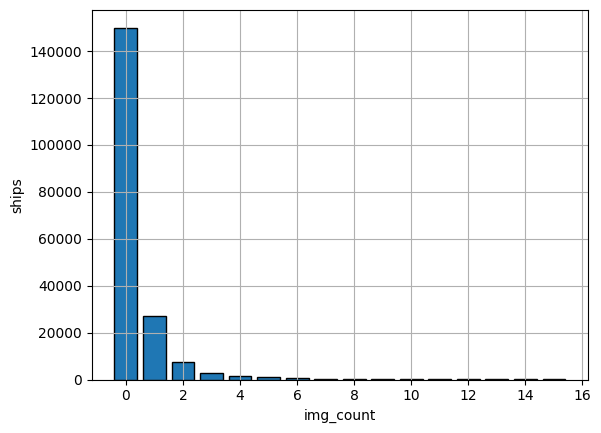

In [9]:

plt.bar(count_img_to_ships['ShipCount'], count_img_to_ships['ImageCount'], edgecolor='black')
plt.xlabel('img_count')
plt.ylabel('ships')
plt.grid(True)
plt.show()

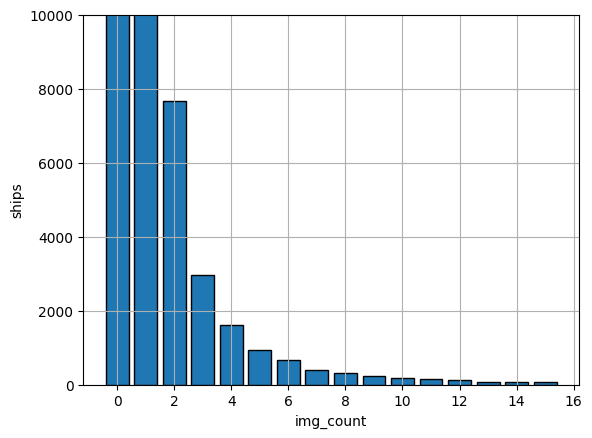

In [17]:

plt.bar(count_img_to_ships['ShipCount'], count_img_to_ships['ImageCount'], edgecolor='black')
plt.xlabel('img_count')
plt.ylabel('ships')
plt.ylim(0, 10_000)
plt.grid(True)
plt.show()

In [76]:
wout_ships = df[df['EncodedPixels'].isna()]
with_ships = df[df['EncodedPixels'].notna()]

reduced_wout_ships = wout_ships.sample(12_000) 

balanced_df = pd.concat([with_ships, reduced_wout_ships])
balanced_df

ImageId                                      EncodedPixels
2       000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3       000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4       000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5       000194a2d.jpg  198320 10 199088 10 199856 10 200624 10 201392...
6       000194a2d.jpg  55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
...               ...                                                ...
39244   2b88ccbf1.jpg                                                NaN
135950  9609fd37e.jpg                                                NaN
146936  a2376c21d.jpg                                                NaN
107578  76680ed3a.jpg                                                NaN
115596  7f7edd59f.jpg                                                NaN

[93723 rows x 2 columns]

In [77]:
balanced_df['EncodedPixels'] = balanced_df['EncodedPixels'].astype(str)

In [78]:
class ShipDataset(Dataset):
    def __init__(self, df, image_dir, image_shape=(768,768), transform=None, preprocessing_fn=None):
        self.df = df
        self.image_dir = image_dir
        self.shape = image_shape
        self.transform = transform
        self.preprocessing_fn = preprocessing_fn
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image_name = self.df.iloc[idx]['ImageId']
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path)
        
        mask = self.get_mask(image_name)
        
        if self.transform:
            image = self.transform(image)
        if self.preprocessing_fn:
            image = self.preprocessing_fn(np.array(image))
        
        return image, mask, image_name
    
    def get_mask(self, image_name):
        rles = self.df[self.df['ImageId'] == image_name]['EncodedPixels'].tolist()
        return self.combine_rle_masks(rles, self.shape)

    def rle_to_mask(self, rle, shape):
        """
        converting RLE string into a mask.

        Parameters:
        rle (str): rle string (format "start1 length1 start2 length2 ...")
        shape (tuple): mask shape (height, width)

        Returns:
        numpy.ndarray: mask as 2D numpy array
        """

        mask = np.zeros(shape[0]*shape[1], dtype=np.uint8)

        if rle == 'nan':
            return mask.reshape(shape)

        rle_nums = list(map(int, rle.split()))

        starts = rle_nums[0::2]
        lengths = rle_nums[1::2]

        starts = [start -1  for start in starts]

        for start, length in zip(starts, lengths):
            mask[start:start + length] = 1

        return mask.reshape(shape).T

    def combine_rle_masks(self, rles, shape):
        """
        Combines several RLE masks into one.

        Parameters:
        rles (list of str): list of rle strings
        shape (tuple): mask shape (height, width)

        Returns:
        torch.Tensor: combined mask as a 2D tensor
        """
        combined_mask = np.zeros(shape, dtype=np.uint8)

        for rle in rles:
            mask = self.rle_to_mask(rle, shape)
            combined_mask = np.maximum(combined_mask, mask)
            
        tensor_combined_mask = torch.tensor(combined_mask, dtype=torch.uint8)

        return tensor_combined_mask
    
   

In [79]:
preprocess = get_preprocessing_fn('resnet34', pretrained='imagenet')

train_df, test_df = train_test_split(balanced_df, train_size=0.8, random_state=42)

train_dataset = ShipDataset(df=train_df, image_dir=img_dir)
test_dataset = ShipDataset(df=test_df, image_dir=img_dir)

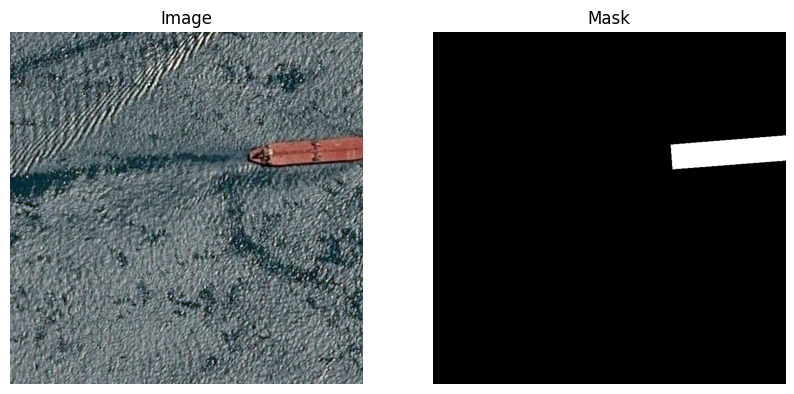

510209334.jpg


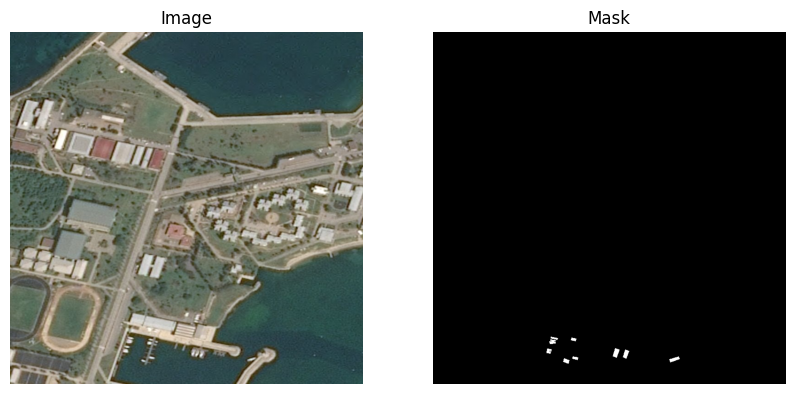

3c027498a.jpg


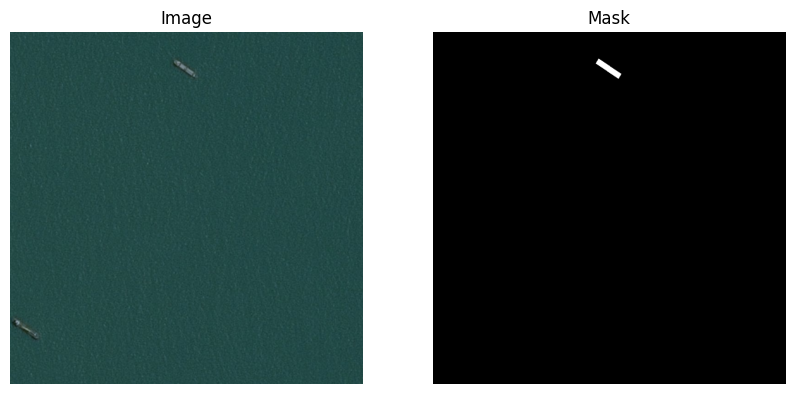

e0f19d64a.jpg


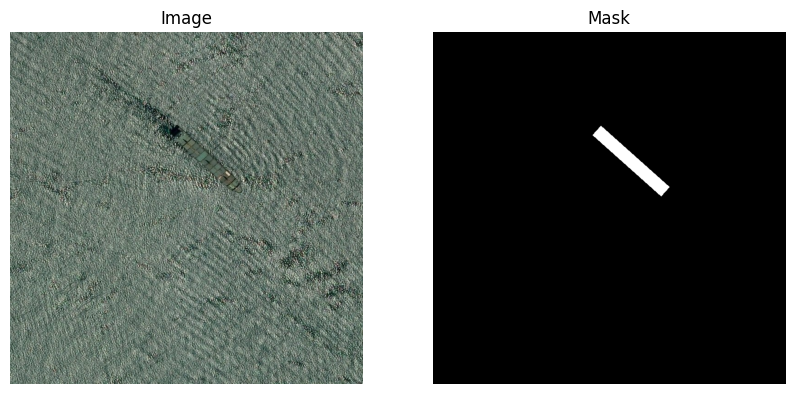

2dcdcb237.jpg


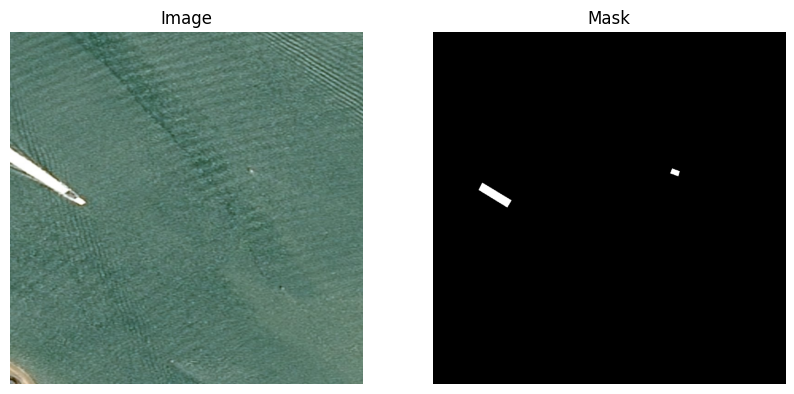

817396702.jpg


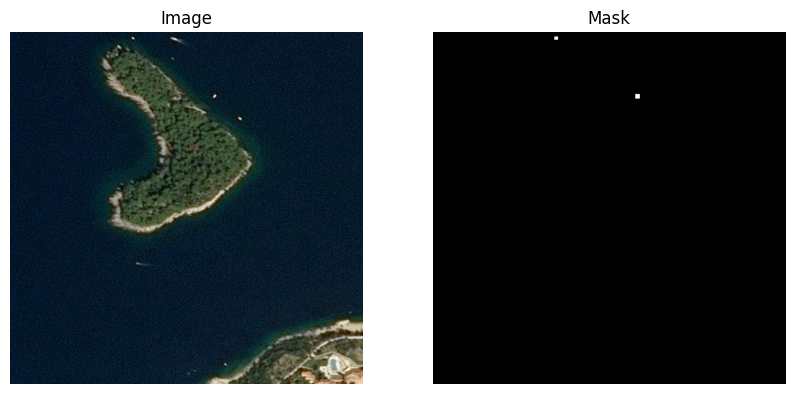

170e28656.jpg


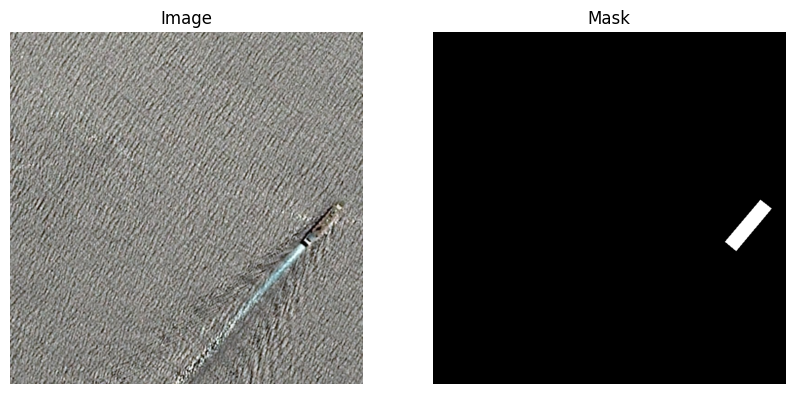

e02e6d367.jpg


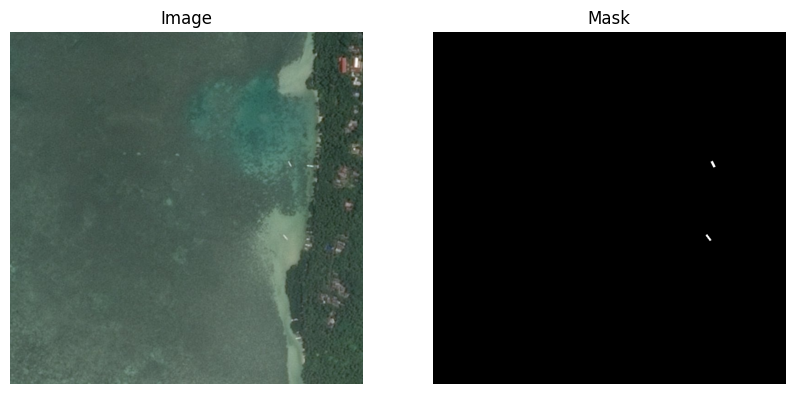

427fa9539.jpg


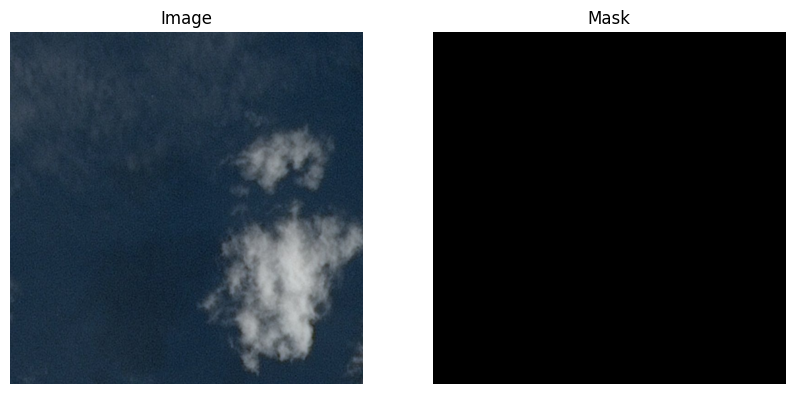

4a44aaaaa.jpg


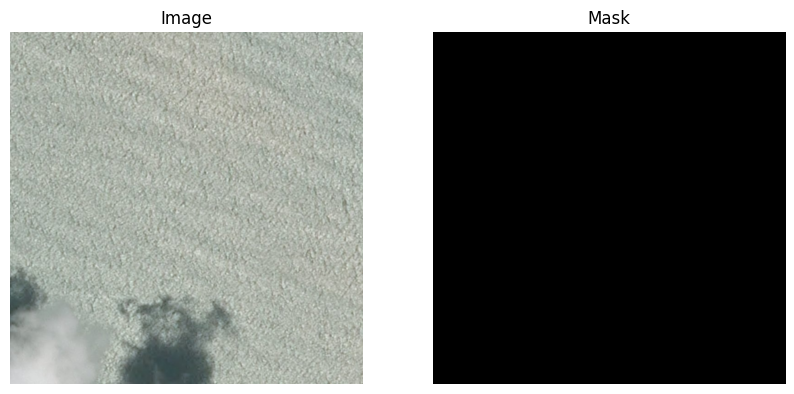

068da9f72.jpg


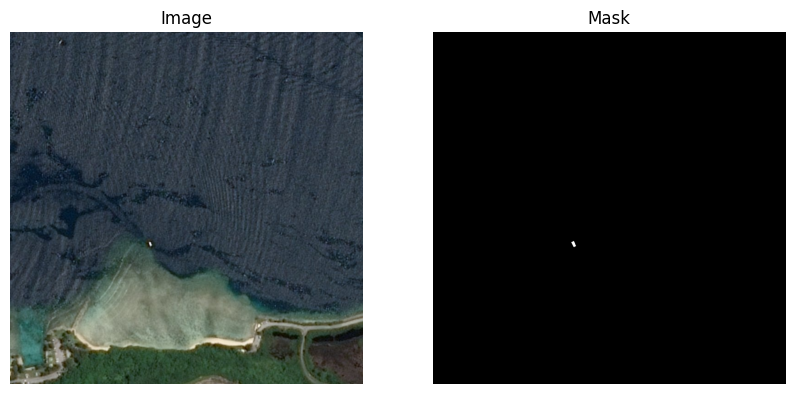

2a99d3b4a.jpg


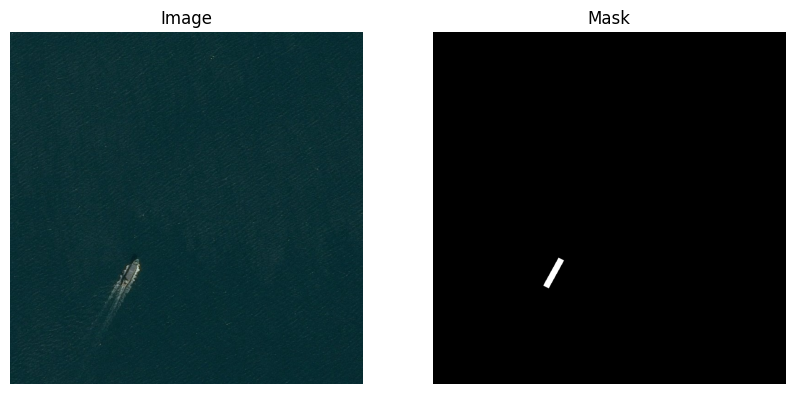

0f0fcb2b3.jpg


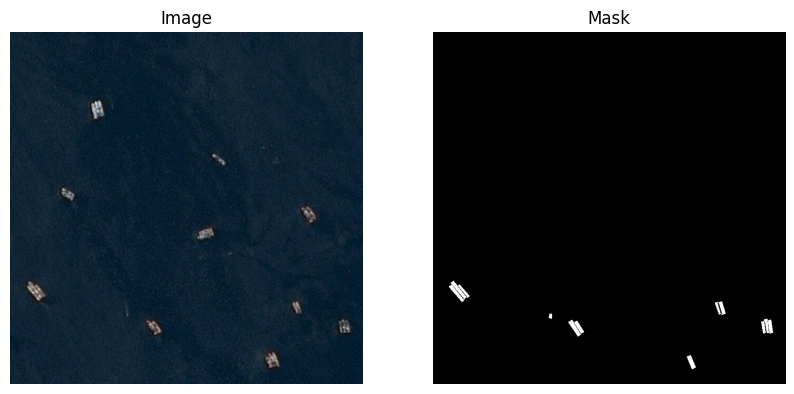

0ba5e5a8a.jpg


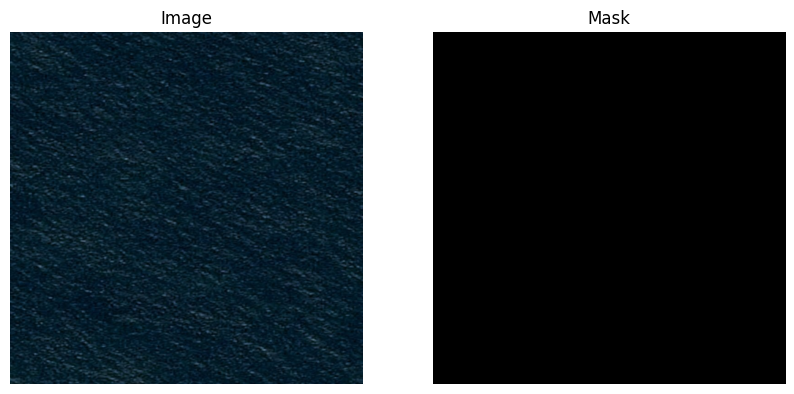

b254f4dd7.jpg


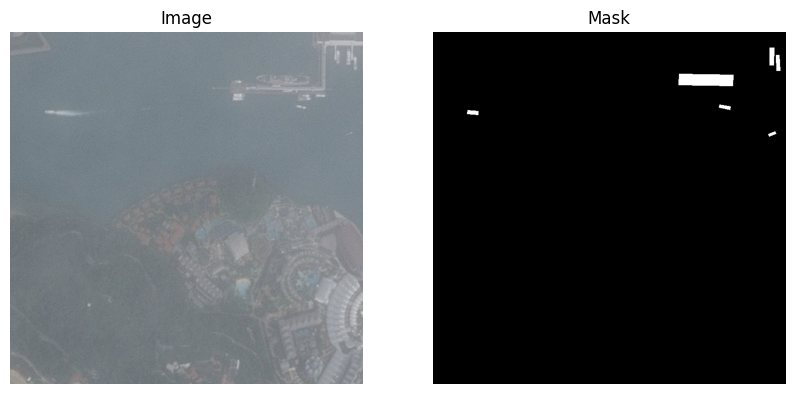

d7eec463c.jpg


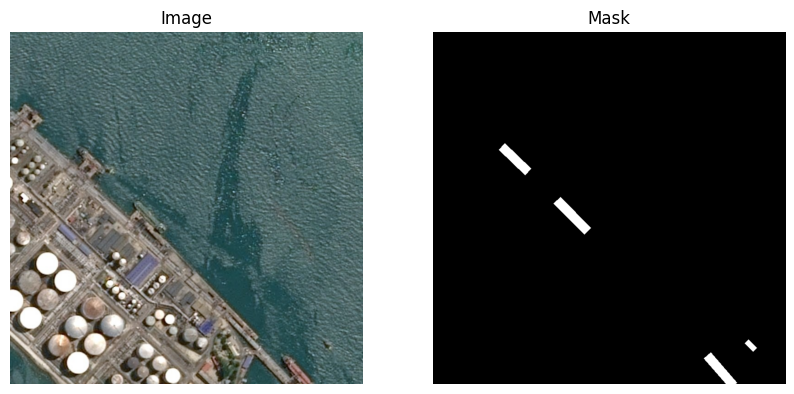

d36d886a3.jpg


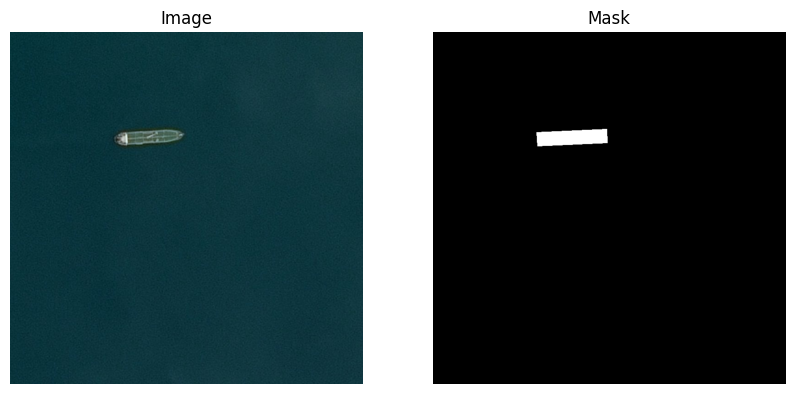

b4825b545.jpg


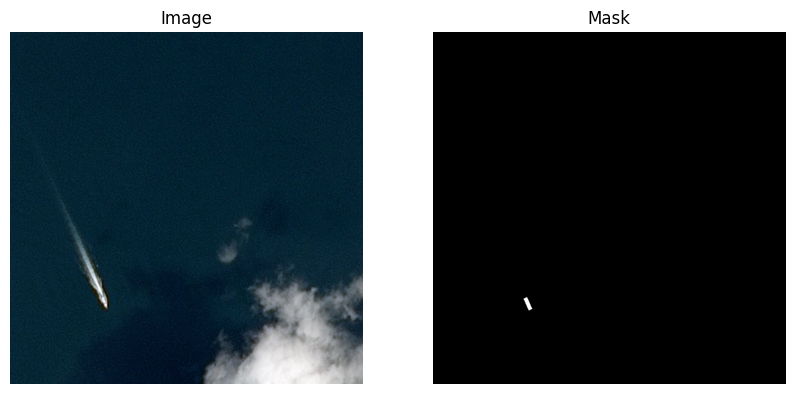

36eb643ff.jpg


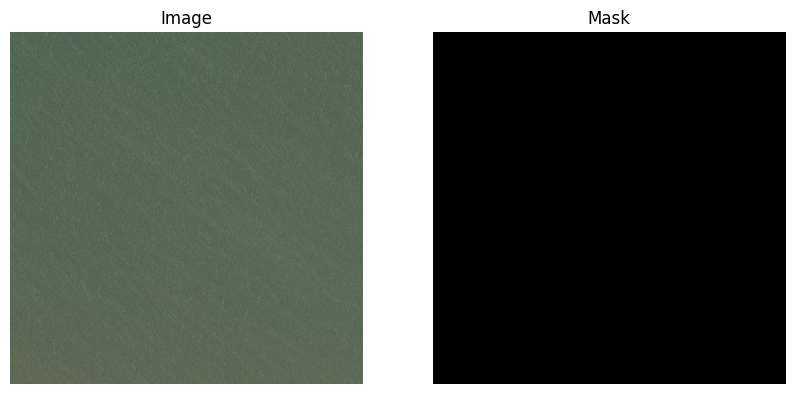

6b6adf215.jpg


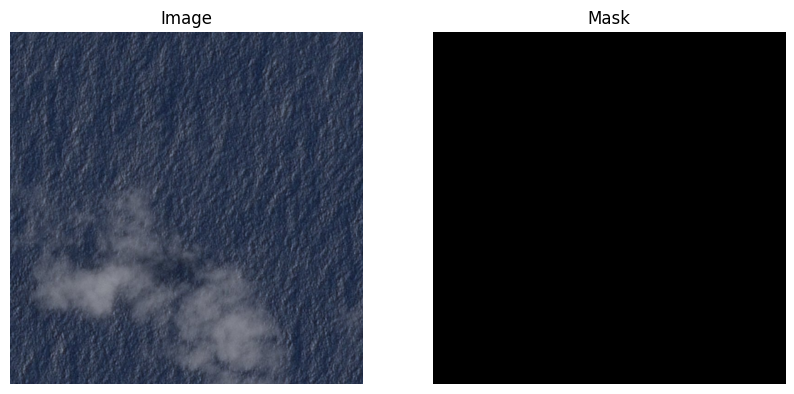

c6694b7e3.jpg


In [80]:
for i in range(20):
    image, mask, image_name = train_dataset[i+12]
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()
    if isinstance(mask, torch.Tensor):
        mask = mask.numpy()

    plt.figure(figsize=(10, 5))  
    plt.subplot(1, 2, 1)  
    plt.imshow(image)  
    plt.title("Image")  
    plt.axis("off")  
    
    plt.subplot(1, 2, 2)  
    plt.imshow(mask, cmap='gray')  
    plt.title("Mask")  
    plt.axis("off")  
    plt.show()  
    print(image_name)

In [81]:
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)